# 4. Modelado

In [ ]:
# Paquetes necesarios
import sys
sys.path.append("./.local/lib/python3.6/site-packages")
import logging
import logging.config
logger = logging.getLogger()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('example7.log')
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
fh.setFormatter(formatter)
logger.addHandler(fh)
import pandas as pd
import numpy as np

In [ ]:
from sklearn import svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

In [ ]:
import random
import pylab as pl
import matplotlib.pyplot as plt
from scipy import optimize
import time
import pandas as pd
from time import time
import numpy as np

En esta sección del documento se presentan los modelos que se estructuraron para intentar resolver el problema de este proyecto. Las secciones de esta fase es el diseño de prueba, la selección del modelo por medio de un benchmark y por último el ajuste de modelos. 

4.1 Diseño de prueba de modelo 

Se corrieron diferentes modelos sin mucha precisión para identificar posibles candidatos.

In [ ]:
#Definimos nuestro train set
train = pd.read_csv('train_clean.csv')
train['TripType'] = train['TripType'].astype('category')
train.head()

In [ ]:
y_train = train['TripType']
y_train = pd.DataFrame(y_train).iloc[:,0]
y_train.shape

In [ ]:
#Aquí escalamos nuestras variables y generamos las dummy por día
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
scaler = StandardScaler()
X_train = train
X_train = X_train.iloc[:,3:len(X_train.columns)]
X_train = pd.get_dummies(X_train, 'Weekday')
scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,0:61]), columns = X_train.columns[0:61]).reset_index(drop = True)
no_scaled = X_train.iloc[:,61:68].reset_index(drop = True)
X_train = pd.concat([scaled, no_scaled], axis = 1)
X_train = pd.DataFrame(X_train)

In [ ]:
#Aquí cargamos el test set
test = pd.read_csv('test_clean.csv')
test.head()

In [ ]:
#Repetimos el proceso
scaler = StandardScaler()
X_test = test
X_test = X_test.iloc[:,2:len(X_test.columns)]
X_test = pd.get_dummies(X_test, 'Weekday')
scaled = pd.DataFrame(scaler.fit_transform(X_test.iloc[:,0:61]), columns = X_test.columns[0:61]).reset_index(drop = True)
no_scaled = X_test.iloc[:,61:68].reset_index(drop = True)

In [ ]:
# Este es el equeleto del entregable final para Kaggle
sample = pd.read_csv('sample_submission.csv')

In [ ]:
logistico = LogisticRegression(random_state= 1)
logistico.fit(X_train, y_train)
logit_result = logistico.predict_proba(X_test)
logistico.score(X_train, y_train)

In [ ]:
GB = GradientBoostingClassifier(random_state=1)
GB.fit(X_train, y_train)
GB_result = GB.predict_proba(X_test)
GB.score(X_train, y_train)

In [ ]:
RF = RandomForestClassifier(random_state=1)
RF.fit(X_train, y_train)
RF_result = RF.predict_proba(X_test)
RF.score(X_train, y_train)

4.2 Benchmark de modelos

De los modelos estimados 'en sucio' el mejor candidato es la regresión logística. A partir de este, se realizó el ajuste para los hiperparámetros y definir el mejor modelo.

4.3 Ajuste de parámetros

In [ ]:
#pone semillas previamente seleccionadas 
np.random.seed(seed=29123)
seed = 918739837
random.seed(21321)

In [ ]:
def define_hyper_params():
    """
        Esta función devuelve un diccionario con
        los clasificadores que vamos a utilizar y
        una rejilla de hiperparámetros
    """
    clfs = {'RF': RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=seed),
        'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy', random_state=seed),
        'LR': LogisticRegression(penalty='l1', C=1e3, random_state=seed),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10, random_state=seed),
            }

    grid = { 
    'RF':{'n_estimators': [1,500,700], 'max_depth': [1,3,10,12], 'max_features': ['sqrt','log2'],'min_samples_split': [2,3,5], 'random_state': [seed]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.0001,0.001,0.01,0.1,1], 'random_state': [seed]},
    'ET': { 'n_estimators': [1,10,25], 'criterion' : ['gini', 'entropy'] ,'max_depth': [1,3,5,7], 'max_features': ['sqrt','log2'],'min_samples_split': [2,3,5], 'random_state': [seed]},
    'GB': {'n_estimators': [1,10,25], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,7], 'random_state': [seed]}
           }

    return clfs, grid

In [ ]:
def magic_loop(models_to_run, clfs, grid, X_train_scaled, y_train, X_test_scaled, y_test, cv = 5,ParamTun = 'GridSearchCV'):
    """
        Esta función ejecuta todos los modelos que se van a correr
        y lo hace ya sea utilizando GridSearchCV o RandomSearchCV. 
        Esta última elige aleatoriamente de entre los hiperparámetros
        que consideramos en la funcion define_hyper_param. Para 
        GridSearch se ejecuta también cross validation. Las métricas
        se guardan en una bitacora por medio de logging y ademas se 
        muestran en la salida de la terminal.
    """
    for n in range(1, 2):
        for index, clf in enumerate([clfs[x] for x in models_to_run]):
            logger.debug(models_to_run[index])
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            try:
                if(ParamTun == 'GridSearchCV'):
                    grid_search = GridSearchCV(clf, parameter_values, cv=cv)
                    start = time()
                    if random.choice([True, False]):
                        modelo = grid_search.fit(X_train_scaled, y_train)
                        y_pred = modelo.predict(X_test_scaled)
                        scaled = True
                    else:
                        modelo = grid_search.fit(X_train, y_train)
                        y_pred = modelo.predict(X_test)
                        scaled = False

                    logger.debug("Best parameters set found on development set with GridSearchCV {}:".format(scaled))
                    logger.debug(" ")
                    logger.debug(modelo.best_params_)
                    logger.debug(" ")
                    logger.debug("Grid scores on development set:")
                    logger.debug(" ")
                    means = modelo.cv_results_['mean_test_score']
                    stds = modelo.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, modelo.cv_results_['params']):
                        logger.debug("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    logger.debug(" ")

                    if models_to_run[index] != "LR":
                        print("dentro de accuracy con {}".format(models_to_run[index]))
                        logger.debug("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
                        logger.debug(metrics.classification_report(y_pred, y_test))
                    else:
                        print("fuera de accuracy con {}".format(models_to_run[index]))
                        if scaled:
                            logger.debug("R2: {}".format(modelo.score(X_test_scaled, y_test))) ## Devuelve el R^2
                        else:
                            logger.debug("R2: {}".format(modelo.score(X_test, y_test))) ## Devuelve el R^2
                    logger.debug("grid_search took %.2f seconds" % (time() - start))

                    print("Best parameters set found on development set with GridSearchCV {}:".format(scaled))
                    print(" ")
                    print(modelo.best_params_)
                    print(" ")
                    print("Grid scores on development set:")
                    print(" ")
                    means = modelo.cv_results_['mean_test_score']
                    stds = modelo.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, modelo.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print(" ")

                    print("grid_search took %.2f seconds" % (time() - start))
                    if models_to_run[index] !="LR":
                        print("dentro de accuracy con {}".format(models_to_run[index]))
                        print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
                        print(metrics.classification_report(y_pred, y_test))
                    else:
                        print("fuera de accuracy con {}".format(models_to_run[index]))
                        if scaled:
                            print("R2: {}".format(modelo.score(X_test_scaled, y_test)))
                        else:
                            print("R2: {}".format(modelo.score(X_test, y_test)))
                else:
                    start = time()
                    random_search = RandomizedSearchCV(clf, parameter_values)
                    if random.choice([True, False]):
                        modelo = random_search.fit(X_train_scaled, y_train)
                        y_pred = modelo.predict(X_test_scaled)
                        scaled = True
                    else:
                        modelo = random_search.fit(X_train, y_train)
                        y_pred = modelo.predict(X_test)
                        scaled = False

                    logger.debug("Best parameters set found on development set with RandomizedSearchCV {}:".format(scaled))
                    logger.debug(" ")
                    logger.debug(modelo.best_params_)
                    logger.debug(" ")
                    logger.debug("Grid scores on development set:")
                    logger.debug(" ")

                    if models_to_run[index] != "LR":
                        print("dentro de accuracy con {}".format(models_to_run[index]))
                        logger.debug("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
                        logger.debug(metrics.classification_report(y_pred, y_test))
                    else:
                        print("fuera de accuracy con {}".format(models_to_run[index]))
                        if scaled:
                            logger.debug("R2: {}".format(modelo.score(X_test_scaled, y_test))) ## Devuelve el R^2
                        else:
                            logger.debug("R2: {}".format(modelo.score(X_test, y_test))) ## Devuelve el R^2
                    logger.debug("RandomizedSearchCV took %.2f seconds" % (time() - start))

                    print("Best parameters set found on development set with RandomizedSearchCV {}:".format(scaled))
                    print(" ")
                    print(modelo.best_params_)
                    print(" ")
                    print("Grid scores on development set:")
                    print(" ")

                    print("RandomizedSearchCV took %.2f seconds" % (time() - start))
                    if models_to_run[index] != "LR":
                        print("dentro de accuracy con {}".format(models_to_run[index]))
                        print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))
                        print(metrics.classification_report(y_pred, y_test))
                    else:
                        print("fuera de accuracy con {}".format(models_to_run[index]))
                        if scaled:
                            print("R2: {}".format(modelo.score(X_test_scaled, y_test)))
                        else:
                            print("R2: {}".format(modelo.score(X_test, y_test)))
            except IndexError as e:
                print('Error:', e)
                continue

In [ ]:
def main(): 
    # Se obtienen los hyperparametros
    clfs, grid = define_hyper_params()
    #Se especifican los modelos que se van a ejecutar
    models_to_run_GS=['RF','LR','GB']
    models_to_run_RS=['RF','LR','GB']
    
    #Se carga la base de datos y se divide el set de entrenamiento en uno para entrenar y otro para validacion
    train = pd.read_csv('train_final.csv')
    train['TripType'] = train['TripType'].astype('category')
    scaler = StandardScaler()
    X = train
    X = X.iloc[:,3:len(X.columns)]
    X = pd.get_dummies(X, 'Weekday')
    y = train['TripType']
    y = pd.DataFrame(y).iloc[:,0]
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1273483)


    #Se escalan los datos de entrenamiento
    scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,0:61]), columns = X_train.columns[0:61]).reset_index(drop = True)
    no_scaled = X_train.iloc[:,61:68].reset_index(drop = True)
    X_train = pd.concat([scaled, no_scaled], axis = 1)
    X_train = pd.DataFrame(X_train)

    #Se escalan los datos de validacion
    scaled = pd.DataFrame(scaler.fit_transform(X_val.iloc[:,0:61]), columns = X_val.columns[0:61]).reset_index(drop = True)
    no_scaled = X_val.iloc[:,61:68].reset_index(drop = True)
    X_val = pd.concat([scaled, no_scaled], axis = 1)
    X_val = pd.DataFrame(X_val)

    #Se corre el bucle con RandomSearch
    magic_loop(models_to_run_RS, clfs, grid, X_train, y_train, X_val, y_val, cv = 5, ParamTun = 'RandomSearchCV')
    #Se corre el bucle con GridSearch
    magic_loop(models_to_run_GS, clfs, grid, X_train, y_train, X_val, y_val, cv = 5, ParamTun = 'GridSearchCV')

In [ ]:
if __name__ == '__main__':
    main()

Los resultados se encuentran en los archivos .txt anexos

# 5. Evaluación 

5.1, 5.2 Evaluación del modelo final con conjunto de prueba y reentrenamiento con hiperparámetros optimizados

Con los parámetros que tuvierón una mejor precisión se corrieron los mejores modelos.

In [ ]:
logistico = LogisticRegression(random_state= 918739837, penalty='l1', C= 1)
logistico.fit(X_train, y_train)
logit_result = logistico.predict_proba(X_test)
logistico.score(X_train, y_train)

In [ ]:
GB = GradientBoostingClassifier(random_state=918739837)
GB.fit(X_train, y_train)
GB_result = GB.predict_proba(X_test)
GB.score(X_train, y_train)

In [ ]:
RF = RandomForestClassifier(random_state=918739837)
RF.fit(X_train, y_train)
RF_result = RF.predict_proba(X_test)
RF.score(X_train, y_train)

Se observa que los mejores modelos son el GBoost y la regresión lógistica; posiblemente porque estos captan la relación no aleatoria entre el tipo de visita y los patrones de consumo

5.3 Generación y carga de datos de prueba en Kaggle

Estos son los datos que se subieron a la competencia en Kaggle. A continuación se muestra la tabla con los resultados

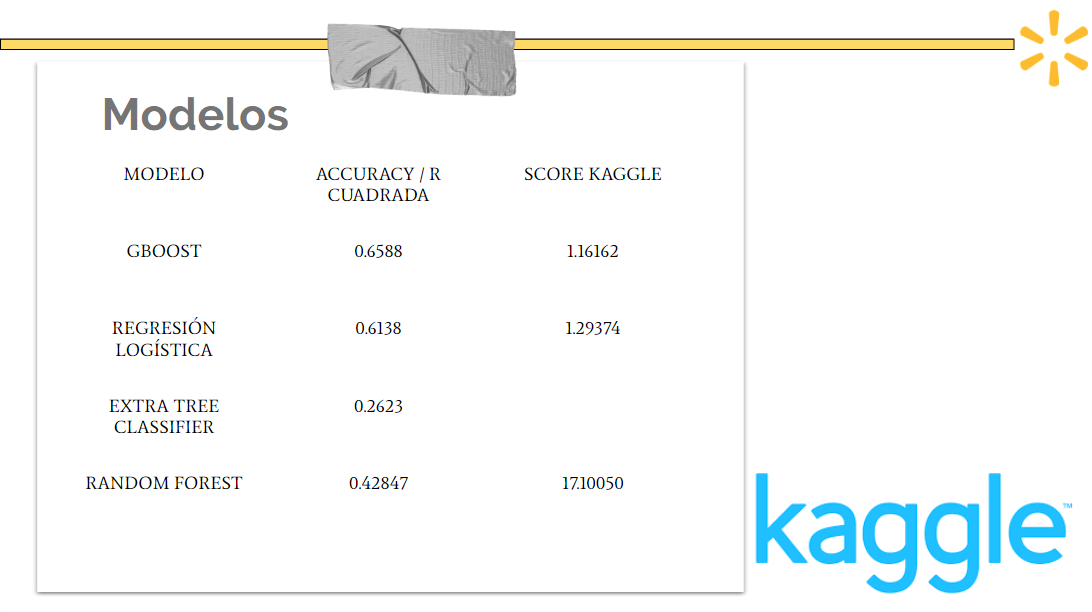

In [ ]:
for columna in range(RF_result.shape[1]):
    sample.iloc[:,columna+1] = RF_result[:,columna]
sample.to_csv('RF.csv', index=False)

for columna in range(GB_result.shape[1]):
    sample.iloc[:,columna+1] = GB_result[:,columna]
sample.to_csv('GB_std.csv', index=False)

for columna in range(logit_result.shape[1]):
    sample.iloc[:,columna+1] = logit_result[:,columna]
sample.to_csv('GB_std.csv', index=False)

# Implantación

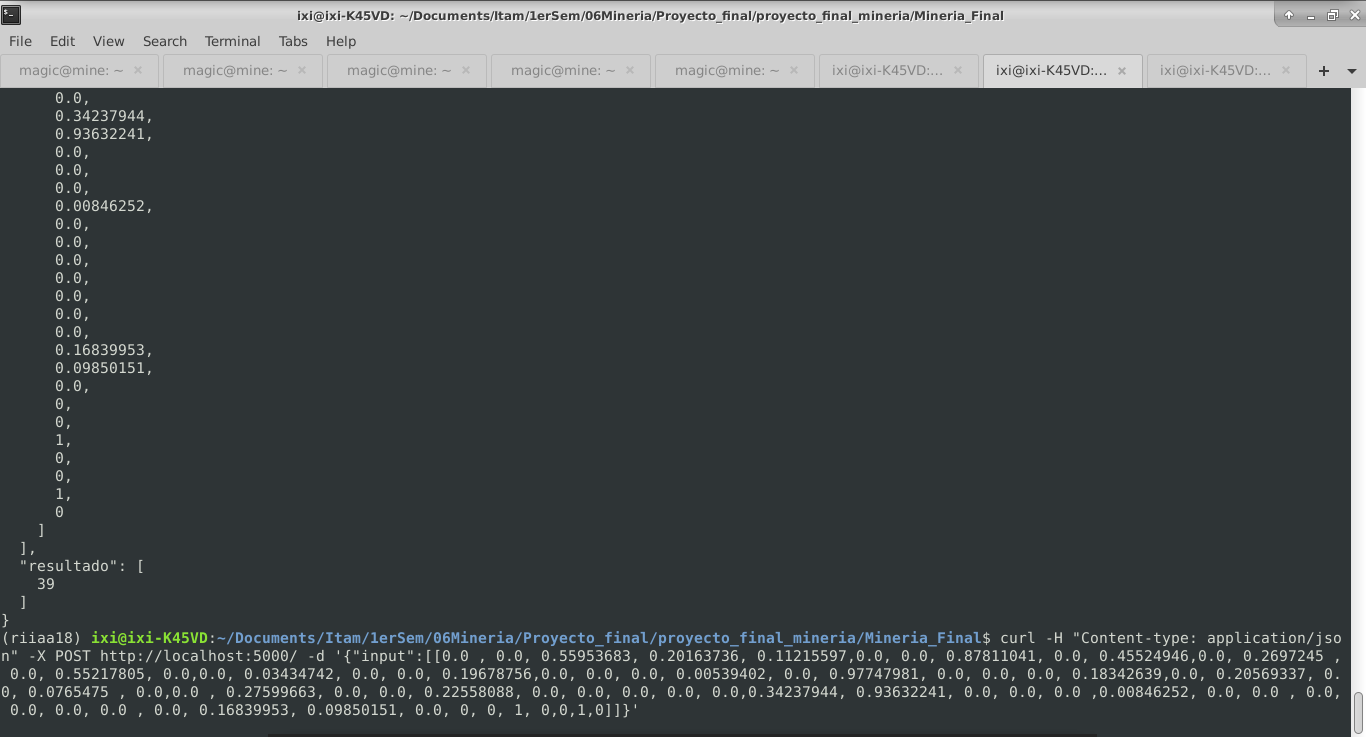